#**Projeto Exemplo de Classificação de Tipos de Flores - Etapa 2**

### Este Notebook detalha todas as etapas referentes a segunda entrega para um projeto de exemplo.

### O código à seguir foi retirado do seguinte repositório do kaggle https://www.kaggle.com/code/a3amat02/fine-tuning-resnet-for-flowers-type-identification. Esta etapa do projeto consiste em 3 sub-etapas:

1. Rodar o código original do kaggle, fazendo um estudo detalhado de cada etapa envolvida. Nesse exemplo serão adicionadas células textuais para explicar o que está sendo feito;

2. Propor melhorias fundamentadas, seja com a finalidade de melhorar o desempenho ou o tempo de execução do algoritmo;

3. Implementar as melhorias propostas e apresentar os resultados comparativos entre o código original e o código após a implementação das melhorias propostas.

**Explicação: O código a seguir configura um ambiente de notebook para trabalhar com dados do Kaggle, baixando e descompactando arquivos de fontes externas. Ele cria diretórios específicos para armazenar dados (/kaggle/input e /kaggle/working), cria links simbólicos para esses diretórios, e então baixa arquivos especificados pela variável DATA_SOURCE_MAPPING. Cada fonte de dados é baixada em blocos (chunks), exibindo o progresso, e depois descompactada no diretório adequado. O código trata diferentes tipos de arquivos comprimidos (.zip ou .tar), lidando com erros de download e finalizando com uma mensagem de sucesso ao concluir o processo de importação dos dados.**

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flowers-five-classes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5486836%2F9092330%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240920%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240920T230107Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D63784096ff4e924aee9f934b296ba091dc900f661575de26817dd3eb8b96cf7ce72053a248e810ef66a180d7e7dc0b53f109e39e52645a80ad561228aebb02b8c738515b5a867d59baace1b73b55fefe22cc64004a15e437f8e41263aac5b8707e98fca47d1814da63c88944176b4ad38abadf937886343b28e010f8e26ced0737a4ffbcf0b99b87f1e48b06cc86aaac95370ebe5d3cb20d388568f0deaabe094c4fc6af19ffbae4661ada8a0d5c3f0b43125c39edbd487a4b0dde324059d37e97df41c6a236dc288a9e86639d0ed4fe1996409395307d5eedfff95ba432e22f48aa923ee71d2512923ec27c7f8c748fb9d5119f09928572f91e85a8ec206e5b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 165528569 bytes downloaded
Downloaded and uncompressed: flowers-five-classes
Data source import complete.


 **Explicação: Este código importa as bibliotecas necessárias para treinar e avaliar um modelo de visão computacional usando o PyTorch e o modelo pré-treinado ResNet-50. Ele inclui bibliotecas para:**
- Processamento de dados com NumPy, Pandas, e Scikit-learn.
- Manipulação e transformação de imagens com OpenCV e torchvision.
- Construção e treinamento de redes neurais profundas com PyTorch.
- Visualização de resultados com Matplotlib e Seaborn.
- Avaliação de desempenho com métricas como accuracy, classification report, e confusion matrix.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from copy import deepcopy

# Criação do Dataset

**Explicação: O código à seguir cria um DataFrame contendo caminhos de imagens e suas respectivas classes (rótulos). Ela percorre um diretório principal, onde as imagens estão organizadas em subpastas, sendo que cada subpasta representa uma classe (ou rótulo). Para cada subpasta, o código coleta os caminhos completos das imagens e associa o nome da subpasta como o rótulo correspondente. O resultado final é uma tabela com duas colunas: "images" (com os caminhos das imagens) e "labels" (com a classe/rótulo a que cada imagem pertence).**

In [ ]:
def create_df(path):
    dd = {"images": [], "labels": []}

    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        for j in os.listdir(img_dir):
            dd["images"] += [os.path.join(img_dir, j)]
            dd["labels"] += [i]

    return pd.DataFrame(dd)

# Import do Dataset

**Explicação: Estas linhas criam um DataFrame com caminhos de imagens e suas classes, e depois convertem essas classes de texto (por exemplo, nomes de flores) em valores numéricos, prontos para serem usados em um modelo de aprendizado de máquina.**

In [ ]:
df = create_df("/kaggle/input/flowers-five-classes/train")

le = LabelEncoder()

df["labels"] = le.fit_transform(df["labels"].values)

# Hiperparâmetros de treinamento


**Explicação: Hiperparâmetros são variáveis ajustáveis definidas pelo usuário que controlam o comportamento e o desempenho de um modelo de aprendizado de máquina. Eles não são aprendidos pelo modelo durante o treinamento, mas são escolhidos antes do processo de treinamento para otimizar os resultados. À seguir são descritos os hiperparâmetros definidos na sequência:**

- EPOCHS: Número de vezes que o modelo passará por todo o conjunto de dados de treinamento. Mais epochs podem resultar em um modelo melhor treinado, mas também aumentam o risco de overfitting.

- LR (Learning Rate): Taxa de aprendizado, que controla o tamanho dos ajustes que o modelo faz nos pesos a cada passo de otimização. Um valor alto acelera o treinamento, mas pode dificultar a convergência para o mínimo ideal.

- GAMMA: Fator de redução da taxa de aprendizado. Usado com técnicas de agendamento, como o StepLR, para reduzir o valor de LR após certos intervalos de tempo.

- STEP: Número de epochs após o qual a taxa de aprendizado será reduzida. Combinado com GAMMA. Neste caso, combinado com GAMMA, ajusta a taxa de aprendizado a cada 7 epochs.

- IMG_SIZE: Tamanho das imagens de entrada (altura e largura) que o modelo irá processar. Neste caso, as imagens serão redimensionadas para 224x224 pixels.

- BATCH = 128: Tamanho do batch, ou seja, o número de amostras de imagens processadas antes de atualizar os pesos do modelo. Batches maiores aceleram o treinamento, mas exigem mais memória.

- OUT_SIZE: Número de classes que o modelo deve prever, neste caso, 5 categorias ou rótulos de saída.

In [ ]:
EPOCHS = 10
LR = 0.1
GAMMA = 0.1
STEP = 7
IMG_SIZE = 224
BATCH = 128
OUT_SIZE = 5

# Pipeline de Pré-processamento do Dataset



**Explicação: A classe Pipeline é usada para carregar, pré-processar e transformar imagens de um conjunto de dados. Quando solicitada, ela recupera uma imagem pelo caminho, aplica as transformações (como redimensionamento ou normalização), e retorna a imagem transformada junto com seu rótulo correspondente. Isso facilita o treinamento de redes neurais, pois o PyTorch pode usar essa classe para carregar as imagens de forma eficiente.**

In [ ]:
class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data[x, 0], self.data[x, 1]

        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = self.transform(img)

        return img, label

# Configuracão do pré-processamento e definição do pipeline de transformação de imagem

**Explicação: Este código configura um pipeline de transformação de imagens e divide um conjunto de dados em conjuntos de treinamento, validação e teste, além de preparar os DataLoaders para facilitar o carregamento dos dados durante o treinamento de um modelo.**

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train, validating = train_test_split(df.values, random_state=42, test_size=0.2)
val, test = train_test_split(validating, random_state=42, test_size=0.5)

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

# Importando ViT e adicionando camada de ativação softmax no topo, definindo dispositivo de treinamento com ferramentas de treinamento

**Explicação: O código carrega um modelo ResNet-50 pré-treinado, adapta sua camada de saída para um novo número de classes, define uma nova classe para a rede, e prepara o modelo para treinamento em um dispositivo (GPU ou CPU). Ele também configura a função de perda, o otimizador e o agendador de taxa de aprendizado para o processo de treinamento.**

In [ ]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

class ResNet50(nn.Module):
    def __init__(self, model):
        super(ResNet50, self).__init__()
        self.model = model

    def forward(self, x):
        return nn.functional.softmax(self.model(x), dim=1)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = ResNet50(resnet)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


cuda


# Loop de Treinamento

**Explicação: Este código realiza o treinamento de um modelo de aprendizado de máquina em um loop de épocas, avaliando o desempenho tanto no conjunto de treinamento quanto no de validação.**

In [ ]:
# Faz uma cópia do modelo atual para armazenar o melhor modelo encontrado durante o treinamento.
best_model = deepcopy(model)

# Inicializa a melhor acurácia de validação como zero.
best_acc = 0

# Listas vazias para armazenamento da perda e acurácia de treinamento e validação ao longo das épocas
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Cada época de treinamento é uma passagem dos dados no modelo, cálculo de das perdas, acurácia e gradientes e atualização dos pesos do modelo
for i in range(1, EPOCHS+1):

    # Coloca o modelo em modo de treinamento, ativando funcionalidades como a atualização de gradientes.
    model.train()

    # Variáveis para acumular a perda total, a acurácia total e o número total de amostras.
    diff = 0
    acc = 0
    total = 0

    # O loop percorre os dados do DataLoader de treinamento (train_dl).
    for data, target in train_dl:
        optimizer.zero_grad()

        # As imagens e as classes (rótulos) são movidas para a GPU, se disponível.
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # O modelo faz uma previsão (out) com os dados de entrada.
        out = model(data)

        #A perda é calculada com base nas saídas do modelo e nos rótulos reais.
        loss = criterion(out, target)

        #A perda total é atualizada
        diff += loss.item()

        #A acurácia é atualizada
        acc += (out.argmax(1) == target).sum().item()

        # O total de amostras é atualizado
        total += out.size(0)

        # Os gradiente são calculados
        loss.backward()

        # Os pesos do modelo são atualizados
        optimizer.step()

    # Salvamento da perda e da acurácia do treinamento
    train_loss += [diff/total]
    train_acc += [acc/total]

    # Coloca o modelo em modo de avaliação, desativando funcionalidades como a atualização de gradientes
    model.eval()

    diff = 0
    acc = 0
    total = 0

    # O loop percorre os dados do DataLoader de validação (val_dl) sem calcular os gradientes (otimização de memória e tempo).
    # Os mesmos cálculos de perda e acurácia são realizados.
    with torch.no_grad():
        for data, target in val_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    # Salvamento da perda e da acurácia de validação
    val_loss += [diff/total]
    val_acc += [acc/total]

    # Se a acurácia de validação da época atual for maior que a melhor acurácia registrada, o modelo atual é salvo como o melhor modelo.
    if best_acc <= val_acc[-1]:
        best_model = deepcopy(model)
        best_acc = val_acc[-1]

    # Ajuste da taxa de aprendizado
    scheduler.step()

    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1], train_acc[-1],
                                                                   val_loss[-1], val_acc[-1]))

Epoch 1 train loss 0.012627006554212726 acc 0.5364298724954463 val loss 0.015228296626697887 acc 0.8254545454545454
Epoch 2 train loss 0.010328066207889217 acc 0.8410746812386156 val loss 0.012169405330311169 acc 0.88
Epoch 3 train loss 0.008857761575876038 acc 0.9048269581056466 val loss 0.011297913898121226 acc 0.9018181818181819
Epoch 4 train loss 0.008308974255846716 acc 0.9344262295081968 val loss 0.011064004464582963 acc 0.9272727272727272
Epoch 5 train loss 0.00807657677727753 acc 0.9530965391621129 val loss 0.010836791558699174 acc 0.9345454545454546
Epoch 6 train loss 0.007854570972246334 acc 0.970856102003643 val loss 0.010714507319710471 acc 0.9272727272727272
Epoch 7 train loss 0.007736344969337755 acc 0.9799635701275046 val loss 0.010601591196927157 acc 0.9309090909090909
Epoch 8 train loss 0.0076737902474967945 acc 0.9845173041894353 val loss 0.010568680979988792 acc 0.9309090909090909
Epoch 9 train loss 0.007687989561284175 acc 0.9858834244080146 val loss 0.0105676841735

# Visualização do log de Desempenho do Treinamento

**Explicação: Este código é responsável por criar gráficos que visualizam a perda (loss) e a acurácia do modelo durante o treinamento e a validação.**

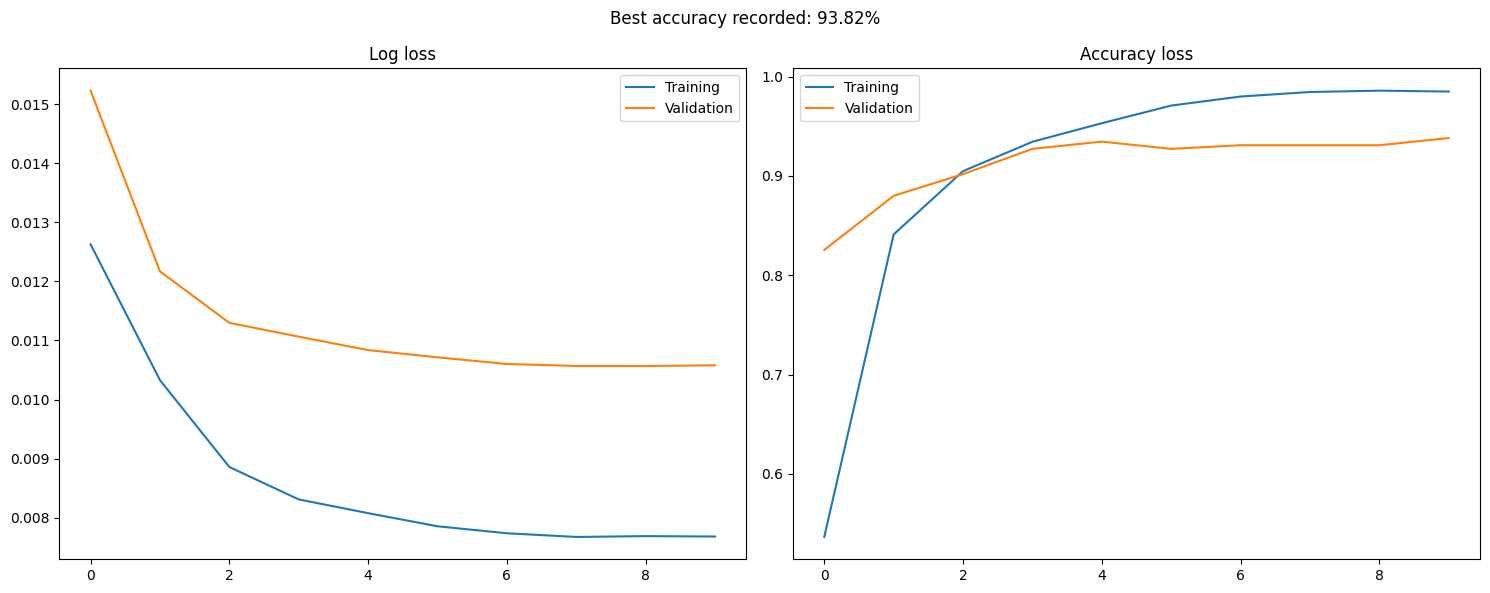

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validation")
axes[index].legend()
axes[index].set_title("Log loss")

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validation")
axes[index].legend()
axes[index].set_title("Accuracy loss")

plt.suptitle("Best accuracy recorded: {}%".format(round(best_acc*100, 2)))

plt.tight_layout()
plt.show()

# Predição, desempenho do modelo de teste e avaliação

**Explicação: A função predict carrega e processa uma imagem, a transforma em um formato compatível com o modelo, e então utiliza o modelo para prever a classe da imagem. Ela retorna tanto o índice da classe prevista quanto a probabilidade dessa classe. Isso permite avaliar com que certeza o modelo fez a previsão.**

In [ ]:
def predict(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = transform(img)
    img = img.view([1, 3, 224, 224])
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)

    index = out.argmax(1).item()

    return index, out[0][index].item()

**Explicação: Este código avalia um modelo de classificação em um conjunto de teste, armazenando rótulos verdadeiros e previsões. Ele gera um relatório de classificação e visualiza a matriz de confusão, mostrando o desempenho do modelo em termos de acurácia e outras métricas.**

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        56
           1       0.97      1.00      0.99        66
           2       0.80      0.80      0.80        45
           3       0.97      0.91      0.94        43
           4       0.89      0.88      0.88        65

    accuracy                           0.92       275
   macro avg       0.91      0.91      0.91       275
weighted avg       0.92      0.92      0.92       275



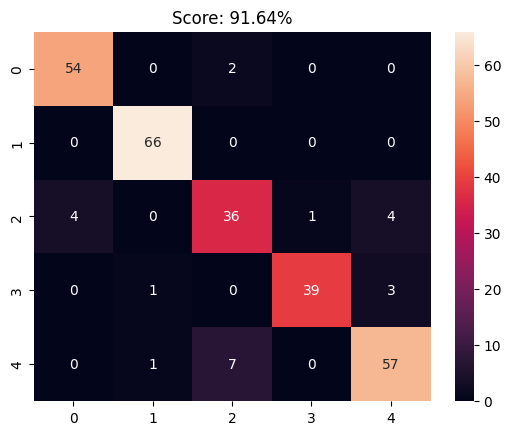

In [ ]:
truth = []
preds = []
probas = []

for i in range(test.shape[0]):
    truth += [test[i, 1]]
    pred, proba = predict(test[i, 0])
    preds += [pred]
    probas += [round(proba*100, 2)]

print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(accuracy_score(preds, truth)*100, 2)))
plt.show()

# Inspeção Visual

**Explicação: O código à seguir visualiza as previsões de um modelo em um conjunto de teste, mostrando 9 imagens em uma grade. Cada imagem é acompanhada de sua previsão, a probabilidade da previsão e o rótulo verdadeiro. Isso ajuda a entender como o modelo está se comportando em relação às classes reais.**

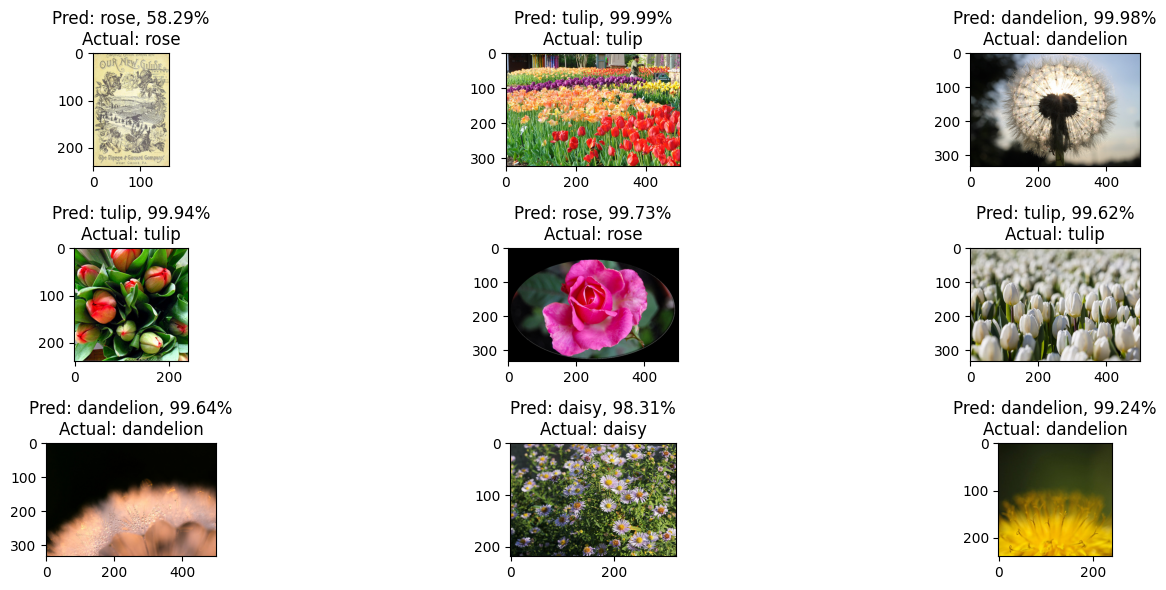

In [ ]:
pred_labels = le.inverse_transform(np.array(preds))
truth_labels = le.inverse_transform(np.array(truth))

index = 0

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(cv2.cvtColor(cv2.imread(test[index, 0]), cv2.COLOR_BGR2RGB))
        axes[i][j].set_title("Pred: {}, {}%\nActual: {}".format(pred_labels[index], probas[index], truth_labels[index]))
        index += 1

plt.tight_layout()
plt.show()

# Ideias de Proposta de Melhorias

Para propor alterações no código considere principalmente ideias de pré-processamento nos dados de entrada, definições dos hiperparâmetros da rede e a arquitetura utilizada. Vamos fazer algumas análises para justificar essas alterações:

- Na primeira etapa do projeto, foi verificada a presença de 5 imagens duplicadas no dataset e no código original não é realizada a remoção dessas imagens, uma alteração que poderia ser adicionada seria justamente essa remoção de duplicatas;

- Ao analisar os gráficos de perda e acurácia presentes na seção Visualização do log de Desempenho do Treinamento, é possível observar que a partir da 7° época não há uma alteração significativa nas métricas de perda e acurácia nem no treinamento e nem na validação, poderíamos então reduzir o número de épocas de 10 para 7 por exemplo, assim reduziríamos o tempo de treinamento e economizaríamos recurso computacional;

- Experimentos com valores distintos para os hiperparâmetros LR, GAMMA, STEP e BATCH, bem como testes de otimizadores diferentes do SGD poderiam ser realizados;

Considere ainda, realizar experimentos com outras arquiteturas populares de redes neurais convolucionais pré-treinadas adequadas para fine-runing, como:


- **VGG16 e VGG19:**
Modelos profundos com uma arquitetura simples, conhecidos pela sua eficácia em tarefas de classificação de imagens.

- **InceptionV3:**
Um modelo que utiliza módulos de convolução de diferentes tamanhos, permitindo capturar características em diferentes escalas.

- **DenseNet (DenseNet121, DenseNet169, DenseNet201):**
Modelos que conectam todas as camadas entre si, facilitando a propagação de gradientes e melhorando a eficiência.

- **MobileNetV2:**
Um modelo leve e eficiente, ideal para dispositivos com recursos limitados. É adequado para aplicações em tempo real.

- **EfficientNet:**
Uma série de modelos que balanceiam profundidade, largura e resolução, oferecendo excelente desempenho com menos parâmetros.

- **Xception:**
Um modelo baseado em convoluções separáveis em profundidade, que pode ser mais eficiente e melhorar a precisão.

- **NASNet:**
Um modelo otimizado para desempenho, gerado por meio de busca automatizada de arquitetura, que se adapta bem a várias tarefas de classificação.

Esses modelos podem ser carregados com pesos pré-treinados em grandes conjuntos de dados, como o ImageNet, e ajustados para a tarefa específica de classificação de flores por meio de fine-tuning.
